# Revisiting Adversarially Learned Injection Attacks Against Recommender Systems
This notebook shows the  self-contained synthetic experiments for the paper "Revisiting Adversarially Learned Injection Attacks Against RecommenderSystems" by Jiaxi Tang, Hongyi Wen and Ke Wang, in ACM conference on Recommender Systems (RecSys) 2020. We will provide step-by-step illustrations to reproduce the results in the paper.

## Import the necessary libraries
Please make sure to have PyTorch version >= 1.3 and install the higher library from https://github.com/facebookresearch/higher

In [1]:
import random
from functools import partial
import numpy as np


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import higher

## Model definition
The two models we used in the paper are:
- `LFM` the standard latent factor model.
- `ItemAE`: the proposed model that could approximate the adversarial gradient with parial derivatives.

In [2]:
class LatentFactorModel(nn.Module):
    def __init__(self, n_users, n_items, hidden_dim):
        super(LatentFactorModel, self).__init__()

        self.n_users = n_users
        self.n_items = n_items
        self.dim = hidden_dim

        self.V = nn.Parameter(
            torch.randn([self.n_items, self.dim]), requires_grad=True)
        self.U = nn.Parameter(
            torch.randn([self.n_users, self.dim]), requires_grad=True)
        self.params = nn.ParameterList([self.V, self.U])

    def forward(self, user_id=None, item_id=None):
        if user_id is None and item_id is None:
            return torch.mm(self.U, self.V.t())
        if user_id is not None:
            return torch.mm(self.U[[user_id]], self.V.t())
        if item_id is not None:
            return torch.mm(self.U, self.V[[item_id]].t())

class ItemAE(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(ItemAE, self).__init__()
        self.q_dims = [input_dim] + hidden_dims
        self.p_dims = self.q_dims[::-1]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
                                       d_in, d_out in
                                       zip(self.q_dims[:-1],
                                           self.q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
                                       d_in, d_out in
                                       zip(self.p_dims[:-1],
                                           self.p_dims[1:])])

    def encode(self, input):
        h = input
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            h = F.selu(h)
        return h

    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.selu(h)
        return h

    def forward(self, data):
        z = self.encode(data.t())
        return self.decode(z).t()

def get_model(name="LFM"):
    model, inner_opt = None, None
    if name == "LFM":
        hidden_dim = 16
        model = LatentFactorModel(n_users, n_items, hidden_dim)
        inner_opt = optim.Adam(model.parameters(), lr=0.5)
    elif name == "ItemAE":
        hidden_dims = [64, 32]
        model = ItemAE(n_users, hidden_dims)
        inner_opt = optim.Adam(model.parameters(), lr=1e-2)

    return model, inner_opt

## Utility functions

### 1) Loss functions
We use the softmax loss as the adversarial objective $\mathcal{L}_{\rm{adv}}$ and the weighted MSE as the surrogate training objective $\mathcal{L}_{\rm{train}}$, one can also define & explore other objectives.

In [3]:
def softmax_cross_entropy_with_logits(logits, targets):
    log_probs = F.log_softmax(logits, dim=1)
    loss = -log_probs * targets
    return loss.sum()

def mse_loss(logits, targets, weight=1):
    weights = torch.ones_like(logits)
    weights[targets > 0] = weight
    loss = weights * (targets - logits)**2
    return loss.sum()

### 2) Functions for adversarial training and evaluation

In [4]:
def set_random_seed(seed, use_cuda):
    random.seed(seed)
    np.random.seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    else:
        torch.manual_seed(seed)

def project_data(data, threshold=0.5):
    result = data.clone()
    return torch.where(result > threshold,
                       torch.ones_like(result), torch.zeros_like(result))

def evaluate(data_x, preds, test_items, target_item=None, cutoff=10):
    test_rankings = []
    target_rankings = []

    filtered_preds = preds.clone()
    filtered_preds.require_grad = False
    filtered_preds[torch.where(data_x)] = -np.inf
    rankings = filtered_preds.argsort(dim=1, descending=True).tolist()

    for user, test_item in enumerate(test_items):
        rank = rankings[user]
        test_rank = rank.index(test_item)
        test_rankings.append(test_rank)
        if target_item is not None:
            target_rank = rank.index(target_item)
            target_rankings.append(target_rank)
    test_rankings = np.asarray(test_rankings)
    target_rankings = np.asarray(target_rankings)

    mean_hr_test = (test_rankings < cutoff).mean()
    mean_rank_test = test_rankings.mean()

    result = {"hr@%d_test" % cutoff: "%.4f" % mean_hr_test,
              "mean_rank_test": "%.4f" % mean_rank_test}
    if target_item is not None:
        mean_hr_target = (target_rankings < cutoff).mean()
        mean_rank_target = target_rankings.mean()
        result["hr@%d_target" % cutoff] = "%.4f" % mean_hr_target
        result["mean_rank_target"] = "%.4f" % mean_rank_target
    return result

## Generate synthetic data
We synthesize a toy datset that is more controllable. Specifically, each data point in $X$ is generated by $x=\mu \nu^\top$, where both $\nu \in \mathcal{R}^d$ and $\mu\in \mathcal{R}^d$ are sampled from $\mathcal{N}_d(\mathbf{0}, \mathbf{I})$ with $d<<\min(|U|, |V|)$. By generating data point for $\forall x \in X$, the synthesized dataset is presumably to have low-rank, similar to other real-world recommendation datsets. Lastly, we binarize $X$ to transform it into implicit feedback data by setting a threshold $\epsilon$. By controlling the value of $(|U|,V|,d,\epsilon)$, we are able to have arbitrary-size synthetic datasets with different ranks and sparsity levels.

Define some hyperparameters for synthetic data generation

In [5]:
n_users = 1000        # number of total users (normal and fake), |U| + |V|
n_items = 300         # number of items |I|
n_fakes = 100         # number of fake user |V|

data_ranks = 20       # synthetic data rank d
binary_threshold = 5  # threshold epsilon

# Without loss of generality, let's suppose we're targeting the item `i0`.
# i.e., we want to push `i0` to true users' recommendation lists.
target_item = 0

Generate the synthetic data following the above procedure

In [6]:
dense_data_x = torch.mm(torch.randn(n_users, data_ranks),
                        torch.randn(data_ranks, n_items))
data_x = torch.zeros_like(dense_data_x)
test_items = np.empty([n_users - n_fakes], dtype=np.int64)
for i, x in enumerate(dense_data_x):
    # Apply thresholding to make synthetic data for implicit feedback.
    x_binary = torch.where(x > binary_threshold,
                           torch.ones_like(x), torch.zeros_like(x))
    
    # For the true users, sample 1 item per user as the test item.
    nnz_inds = torch.nonzero(x_binary).view(-1)
    rand_ind = np.random.randint(0, nnz_inds.shape[0])
    test_item = nnz_inds[rand_ind]
    # Also we have to remove it from training data.
    if i < (n_users - n_fakes):
        x_binary[test_item] = 0.0
        test_items[i] = test_item.item()
    data_x[i] = x_binary

target_x = torch.zeros_like(data_x)
target_x[:, target_item] = 1.0

print(data_x)
print("data sparsity: %.2f" % (1 - data_x.sum().item() / data_x.view(-1).shape[0]))
print(target_x)

tensor([[0., 0., 1.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])
data sparsity: 0.88
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


## Solve the bi-level optimization problem to learn fake data for adversearial goal
Given a well-trained surrogate model that is under-attack and a set of fake users $V = \{v_1, v_2,..,v_{|V|}\}$, the fake data $\widehat{X} \in \{0,1\}^{|V| \times |I|}$ will be learned to optimize an adversarial objective function ${\mathcal{L}_{\rm{adv}}}$:
$$
\min_{\widehat{X}}{\mathcal{L}_{\rm{adv}}}(R_{\theta^*}),
$$
$$
\textrm{subject to}\quad \theta^* = \text{argmin}_\theta \big ( {\mathcal{L}_{\rm{train}}}(X, R_{\theta}) + {\mathcal{L}_{\rm{train}}}(\widehat{X}, \widehat{R}_{\theta}) \big ),
$$

The inner objective (the first minimization in below) shows that after fake data $\widehat{X}$ are injected, the surrogate model will first consume them (i.e., train from scratch with the poisoned dataset), we then obtain the trained model parameters $\theta^*$.
The outer objective (the second minimization in below) shows that after fake data are consumed, we can achieve the malicious goal defined on normal user's predictions $R_{\theta^*}$.

Define some hyperparameters

In [7]:
seed = 1234           # random seed
use_cuda = False      # whether to use GPU
verbose = False       # whether to output full log

n_inner_iter = 100    # epochs for inner optimization
n_outer_iter = 50     # epochs for outer optimization
unroll_epochs = 100   # how many epochs to unroll

# Learning rate and momentum for outer objective optimizer, make sure
# they are carefully tuned for different surrogate and unroll_epochs.
outer_lr = 1.0
outer_momentum = 0.99

surrogate = "LFM"    # which surrogate model to use (LFM or ItemAE)

Adversarial training loop (i.e., algorithm 1 in the paper)

In [8]:
device = "cuda" if use_cuda else "cpu"
set_random_seed(seed, use_cuda)

inner_loss_func = partial(mse_loss, weight=20)
outer_loss_func = softmax_cross_entropy_with_logits

data_x.requires_grad_()
outer_opt = optim.SGD([data_x], lr=outer_lr, momentum=outer_momentum)

data_x = data_x.to(device)
target_x = target_x.to(device)

results = {"adv_loss": [], "hr@10_target": [], "hr@10_test": []}
for j in range(1, n_outer_iter + 1):
    torch.manual_seed(seed)
    model, inner_opt = get_model(surrogate)
    model = model.to(device)
    
    outer_opt.zero_grad()    
    ### Begin: Inner-level optimization
    # Train a few steps without tracking gradients.
    for i in range(1, n_inner_iter - unroll_epochs + 1):
        model.train()
        preds = model() if surrogate == "LFM" else model(data_x)
        inner_loss = inner_loss_func(preds, data_x)
        inner_opt.zero_grad()
        inner_loss.backward()
        inner_opt.step()
        # Evaluate recommendation performance along training steps.
        model.eval()
        result = evaluate(data_x, preds.detach(), test_items)
        if verbose and i % 10 == 0:
            print("inner epoch: %d, loss: %.2f, %s" % (
                i, inner_loss.item(), str(result)))
    # Start using tracking gradients.
    with higher.innerloop_ctx(model, inner_opt) as (fmodel, diffopt):
        if verbose:
            print("Switching to higher mode at epoch %d" % i)
        for i in range(n_inner_iter - unroll_epochs + 1, n_inner_iter + 1):
            fmodel.train()
            preds = fmodel() if surrogate == "LFM" else fmodel(data_x)
            inner_loss = inner_loss_func(preds, data_x)
            diffopt.step(inner_loss)
            # Evaluate recommendation performance along training steps.
            fmodel.eval()
            result = evaluate(data_x, preds.detach(), test_items)
            if verbose and i % 10 == 0:
                print("inner epoch: %d, loss: %.2f, %s" % (
                    i, inner_loss.item(), str(result)))
    ### End: Inner-level optimization
    
    ### Start: outer-level optimization
    preds = fmodel() if surrogate == "LFM" else fmodel(data_x)
    outer_loss = outer_loss_func(preds[:-n_fakes, ],
                                 target_x[:-n_fakes, ])
    results["adv_loss"].append(float("%.4f" % outer_loss.item()))
    grad_x = torch.autograd.grad(outer_loss, data_x)[0]
    # Only change the fake data by setting normal data gradient to 0.
    grad_x[:-n_fakes, :] = 0.0
    if data_x.grad is None:
        data_x.grad = grad_x
    else:
        data_x.grad.data = grad_x
    outer_opt.step()
    # Project fake data onto allowable area.
    data_x.data = project_data(data_x.data, 0.2)
    ### End: outer-level optimization
    
    # Evaluate the recommendation performance and attack performance.
    fmodel.eval()
    preds = fmodel() if surrogate == "LFM" else fmodel(data_x)
    result = evaluate(data_x, preds.detach(), test_items, target_item)
    results["hr@10_target"].append(float(result["hr@10_target"]))
    results["hr@10_test"].append(float(result["hr@10_test"]))
    print("outer epoch: %d, loss: %.2f, %s" % (
        j, outer_loss.item(), str(result)))
    print("-" * 100)

outer epoch: 1, loss: 5154.66, {'hr@10_test': '0.4667', 'mean_rank_test': '23.4811', 'hr@10_target': '0.0389', 'mean_rank_target': '146.0800'}
----------------------------------------------------------------------------------------------------
outer epoch: 2, loss: 4891.29, {'hr@10_test': '0.4778', 'mean_rank_test': '22.6356', 'hr@10_target': '0.1789', 'mean_rank_target': '79.1489'}
----------------------------------------------------------------------------------------------------
outer epoch: 3, loss: 4827.30, {'hr@10_test': '0.4889', 'mean_rank_test': '22.1300', 'hr@10_target': '0.2444', 'mean_rank_target': '62.4244'}
----------------------------------------------------------------------------------------------------
outer epoch: 4, loss: 4804.63, {'hr@10_test': '0.4867', 'mean_rank_test': '22.4878', 'hr@10_target': '0.2800', 'mean_rank_target': '58.0122'}
----------------------------------------------------------------------------------------------------
outer epoch: 5, loss: 4789.

## Visualize the results

Text(0.5, 1.0, 'HR@10 for test item')

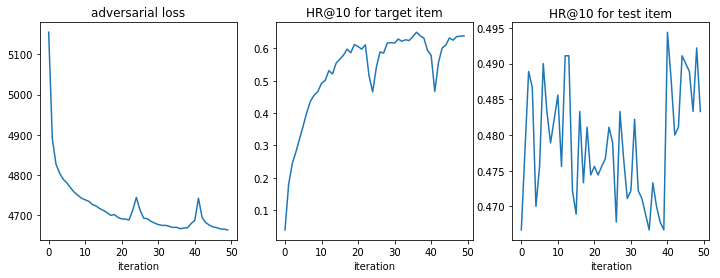

In [9]:
import matplotlib
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.plot(results['adv_loss'])
ax1.set_xlabel("iteration")
ax1.set_title("adversarial loss")

ax2.plot(results['hr@10_target'])
ax2.set_xlabel("iteration")
ax2.set_title("HR@10 for target item")

ax3.plot(results['hr@10_test'])
ax3.set_xlabel("iteration")
ax3.set_title("HR@10 for test item")
